# Multiple classifier testing per fold

In this document, we can apply multiple classifiers for empathy and obtain the average metrics for one of the folds. The folds have been previously managed by WEKA. We have five available folds each divided into a training and testing dataset using the following format:

*   Empathyabase-'+(number of fold)+'tra.csv  for the training set
*   Empathyabase-'+(number of fold)+'tst.csv  for the test set

It is necessary to state the fold number in the code, please refer to further into the code to do so.


In this document, we carry out single-fold analysis and obtain the performance all the classifiers in conjunction. The output includes:

1.   A result text document that describes all the performance metrix per classifier
2.   A confusion matrix text that contains all the printed confusion matrices for all classifiers
3.   Plots for the confusion matrices of all classifiers besides PBC4cip
4.   A document that contains all the patterns obtained from the PBC4cip classifier, as well as its confusion matrix and three classification metrics, this file has the format: PBC4CIP_values_'+(number of fold)+'.txt


### WARNING: The PBC4cip python implementation takes a long time to run. Around an hour per fold. It is much more maneagable to carry out the classification process using this specific classifier in WEKA



In [37]:
pip install pbc4cip

In [38]:
#Importing of libraries necessary for classification and manipulation of database.
import os
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.test.utils import common_texts
from string import punctuation
import numpy as np
from gensim.models import Word2Vec, KeyedVectors
import gensim
import gensim.downloader as gensim_api
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from PBC4cip import PBC4cip
import os
import argparse
import numpy as np
import pandas as pd

from tqdm import tqdm, trange
from PBC4cip import PBC4cip
from PBC4cip.core.Evaluation import obtainAUCMulticlass
from PBC4cip.core.Helpers import get_col_dist, get_idx_val


## Selection of the index for the fold

In [39]:
index = 1

## Creation of classifiers

In [40]:
#Creation of classifiers
rfc = RandomForestClassifier(max_depth=10, random_state=0)
knn = KNeighborsClassifier(n_neighbors=5)
#lreg = LogisticRegression(random_state = 0, penalty = 'l2')
GNB = GaussianNB()
dtc = DecisionTreeClassifier(random_state=0)
xb = XGBClassifier()
nn = MLPClassifier()
pbc = PBC4cip(tree_count = 100) # 100 tree cound og


#Generation of classification array
#classifiers = [rfc,knn,GNB,dtc,nn,pbc]
classifiers = [rfc,knn,GNB,dtc,nn]  # NO PBC4cip
#For visualization of classification array
class_names = ['Random Forest','KNN','Gaussian NB','dtc','MLP'] #NO PBC4cip
#class_names = ['Random Forest','KNN','Gaussian NB','dtc','MLP','PBC4CIP']

## Classification

In [41]:
#Values for each classifier are stored in the array
acc_list = []
recall_list = []
precision_list = []
auc_list = []
confusion_list = []

#Scoring function for PBC4CIP
def score(predicted, y):
        y_class_dist = get_col_dist(y[f'{y.columns[0]}'])
        real = list(map(lambda instance: get_idx_val(y_class_dist, instance), y[f'{y.columns[0]}']))
        numClasses = len(y_class_dist)
        confusion = [[0]* numClasses for i in range(numClasses)]
        classified_as = 0
        error_count = 0

        for i in range(len(real)):
            if real[i] != predicted[i]:
                error_count = error_count + 1
            confusion[real[i]][predicted[i]] = confusion[real[i]][predicted[i]] + 1

        acc = 100.0 * (len(real) - error_count) / len(real)
        auc = obtainAUCMulticlass(confusion, numClasses)

        return confusion, acc, auc


for cls in classifiers:

  #For each of the folds

  data_tra = pd.read_csv('Empathyabase-'+str(index)+'tra.csv')
  data_tst = pd.read_csv('Empathyabase-'+str(index)+'tst.csv')

  #print(data_tra.columns)

  #Preparation
  # We ensure that the variables are taken as categories and not integers or floats

  data_tra['Empathy'] = data_tra['Empathy'].astype('string')
  data_tra["utterance_idx"] = data_tra["utterance_idx"].astype('category')
  data_tra["Talker"] = data_tra["Talker"].astype('category')
  data_tra["context_encoded"] = data_tra["context_encoded"].astype('category')

  data_tst['Empathy'] = data_tst['Empathy'].astype('string')
  data_tst["utterance_idx"] = data_tst["utterance_idx"].astype('category')
  data_tst["Talker"] = data_tst["Talker"].astype('category')
  data_tst["context_encoded"] = data_tst["context_encoded"].astype('category')


  #Separate target values for both training and testing

  X1_train = data_tra.drop(columns=['Empathy'])
  Y1_train = data_tra.drop(columns=X1_train.columns)

  X1_test = data_tst.drop(columns=['Empathy'])
  Y1_test = data_tst.drop(columns=X1_test.columns)


  #For each classifier
  if str(type(cls)) != "<class 'PBC4cip.core.PBC4cip.PBC4cip'>":
    # Sci-kit statistical classifiers

    cls.fit(X1_train,Y1_train)

    y_pred = cls.predict(X1_test)
    acc_score = accuracy_score(Y1_test,y_pred)
    recall_sc = recall_score(Y1_test,y_pred,average='weighted')
    prec_score = precision_score(Y1_test,y_pred,average='weighted')

    pred_prob = cls.predict_proba(X1_test)

    pred_prob_lst = []
    for row in pred_prob:
      arr = []
      for ele in row:
        arr.append(float(ele))
      pred_prob_lst.append(arr)
    auc_sc = roc_auc_score(Y1_test['Empathy'], pred_prob_lst,multi_class='ovr')

    confusion_mat = confusion_matrix(Y1_test, y_pred)
    acc_list.append(acc_score)
    recall_list.append(recall_sc)
    precision_list.append(prec_score)
    auc_list.append(auc_sc)
    confusion_list.append(confusion_mat)


  else:
    #PBC4CIP
    patterns = cls.fit(X1_train, Y1_train)

    y_test_scores = cls.score_samples(X1_test)

    with open('PBC4CIP_values_'+str(index)+'.txt', 'w') as f:
      print('Test Scores:', file=f)

      for i, test_score in enumerate(y_test_scores):
          print(f"{i}: {test_score}",file=f)

      y_pred = cls.predict(X1_test)
      confusion, acc, auc = score(y_pred, Y1_test)
      acc_list.append(acc/100)
      auc_list.append(auc)
      y_pred2 = y_pred

      for i in range(len(y_pred)):
        y_pred2[i] = str(y_pred[i])

      y_pred2 = pd.DataFrame(y_pred2)

      recall_list.append(recall_score(Y1_test, y_pred2, average='weighted'))
      precision_list.append(precision_score(Y1_test, y_pred2, average='weighted'))
      confusion_list.append(confusion)

      print(f"\nPatterns Found:",file=f)
      for pattern in patterns:
          print(f"{pattern}",file=f)

      print(f"\nConfusion Matrix:",file=f)
      for i in range(len(confusion[0])):
          for j in range(len(confusion[0])):
              print(f"{confusion[i][j]} ", end='',file=f)
          print("",file=f)
      print(f"\n\nacc: {acc} , auc: {auc} , numPatterns: {len(patterns)}",file=f)


<ipython-input-41-933650818ded>:64: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  cls.fit(X1_train,Y1_train)


 ## Result display

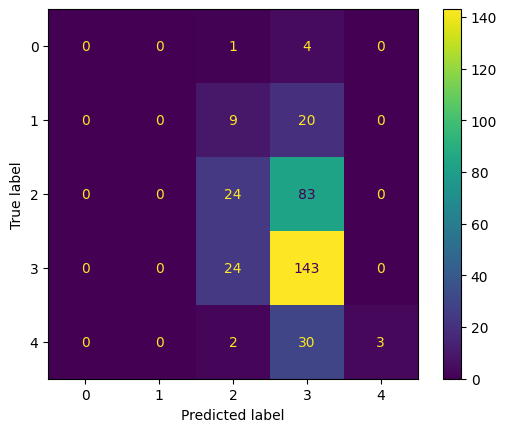

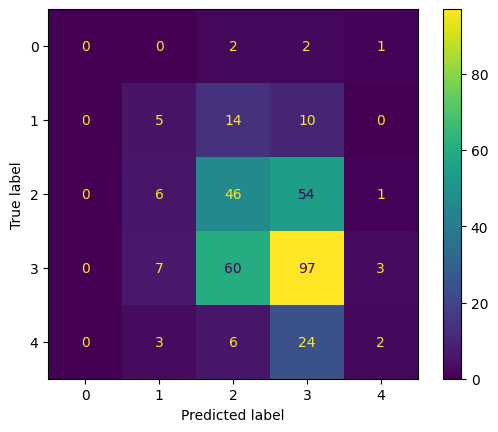

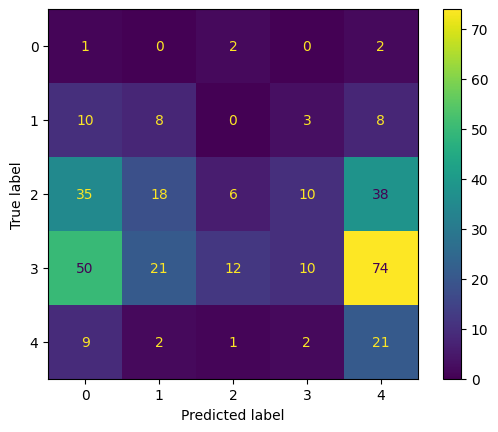

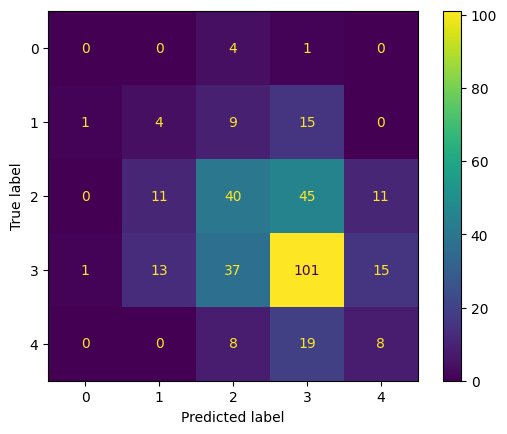

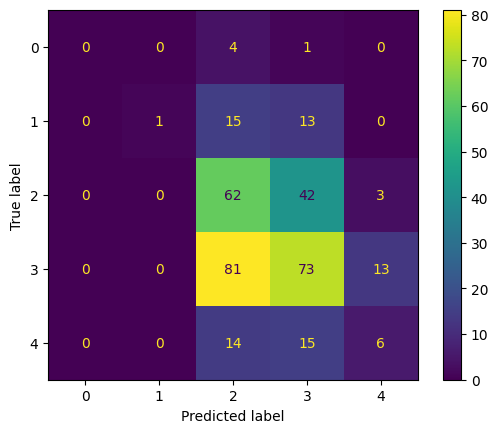

In [44]:
#Results for the average performance through the five folds.

with open('Results_'+str(index)+'.txt', 'w') as f2:
  for i in range(0,len(acc_list)):
    print(type(classifiers[i]).__name__, file=f2)
    print("",file=f2)
    print('Average Accuracy: '+str(acc_list[i]),file=f2)
    print("",file=f2)
    print('Average Recall: '+ str(recall_list[i]),file=f2)
    print("",file=f2)
    print('Average AUC: '+ str(auc_list[i]),file=f2)
    print("",file=f2)
    print('Average Precision: '+ str(precision_list[i]),file=f2)
    print("",file=f2)
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~",file=f2)

with open('Confusion matrices_'+str(index)+'.txt', 'w') as f3:
  for i in range(0,len(acc_list)):
    print(type(classifiers[i]).__name__, file=f3)
    print("",file=f3)
    confusion = confusion_list[i]
    print(f"\nConfusion Matrix:",file=f3)
    print("",file=f3)
    if str(type(classifiers[i])) != "<class 'PBC4cip.core.PBC4cip.PBC4cip'>":
      print(confusion, file = f3)
    else:
     for k in range(len(confusion[0])):
      for j in range(len(confusion[0])):
        print(f"{confusion[k][j]} ", end='',file=f3)
        print("",file=f3)

for i in range(0,len(acc_list)):
    if str(type(classifiers[i])) != "<class 'PBC4cip.core.PBC4cip.PBC4cip'>":
      disp = ConfusionMatrixDisplay(confusion_matrix = confusion_list[i])
      disp.plot()
      plt.savefig(''+type(classifiers[i]).__name__+'.png')

## To obtain the CEM for each of the classifiers, we have provided an Excel file in the repository.